# Polarimetric Whitening Filter (PWF)

In this notebook we compare results of the new implementation of the PWF decomposition with the C legacy version of PolSARpro.  

In [ ]:
%load_ext autoreload
%autoreload 2

import os

from polsarpro.dev.devtools import parse_psp_parameter_string
import numpy as np
from pathlib import Path
import xarray as xr
from polsarpro.io import read_psp_bin, open_netcdf_beam
from polsarpro.util import S_to_C3
from polsarpro.speckle_filters import PWF
import shutil

# optional import for progress bar
from dask.diagnostics import ProgressBar

# change to your local C-PolSARpro install dir
c_psp_dir = "/home/c_psp/Soft/bin/"
os.environ["PATH"]+=os.pathsep+f"{c_psp_dir}/data_process_sngl/"
os.environ["PATH"]+=os.pathsep+f"{c_psp_dir}/speckle_filter/"

# change to your data paths
# original dataset
input_alos_data = Path("/data/psp/test_files/SAN_FRANCISCO_ALOS1_slc.nc")

# input files from C (use S matrix)
input_test_dir = Path("/data/psp/SAN_FRANCISCO_ALOS1/")

# output files from C
output_test_dir = Path("/data/psp/res/pwf_c/")
if not os.path.isdir(output_test_dir):
    os.mkdir(output_test_dir)

## Run the C-version on some test data

In [14]:
input_str = f"""id: {input_test_dir}
od: {output_test_dir}
iodf: S2
nwr: 9
nwc: 9
ofr: 0
ofc: 0
fnr: 18432
fnc: 1248
errf: /tmp"""

result = parse_psp_parameter_string(input_str)
os.system(f"PWF_filter.exe {result}")

# CPSP does not create another config file in output dir
shutil.copy(input_test_dir / "config.txt", output_test_dir)

'/data/psp/res/pwf_c/config.txt'

## Load ALOS data and C outputs

In [15]:
# uncomment to test on S matrix made with SNAP
S = open_netcdf_beam(input_alos_data)

## Apply the decomposition

In [25]:
file_out = "/data/psp/res/test_PWF.nc"
# netcdf writer cannot overwrite
if os.path.isfile(file_out):
    os.remove(file_out)

with ProgressBar():
    res = PWF(S_to_C3(S), train_window_size=[21, 21], test_window_size=[3, 3]).to_netcdf(file_out)

[########################################] | 100% Completed | 50.78 s


In [26]:
out_py = xr.open_dataset(file_out)
out_c = read_psp_bin(output_test_dir / "PWF.bin")

Text(0.5, 1.0, 'C (CLI)')

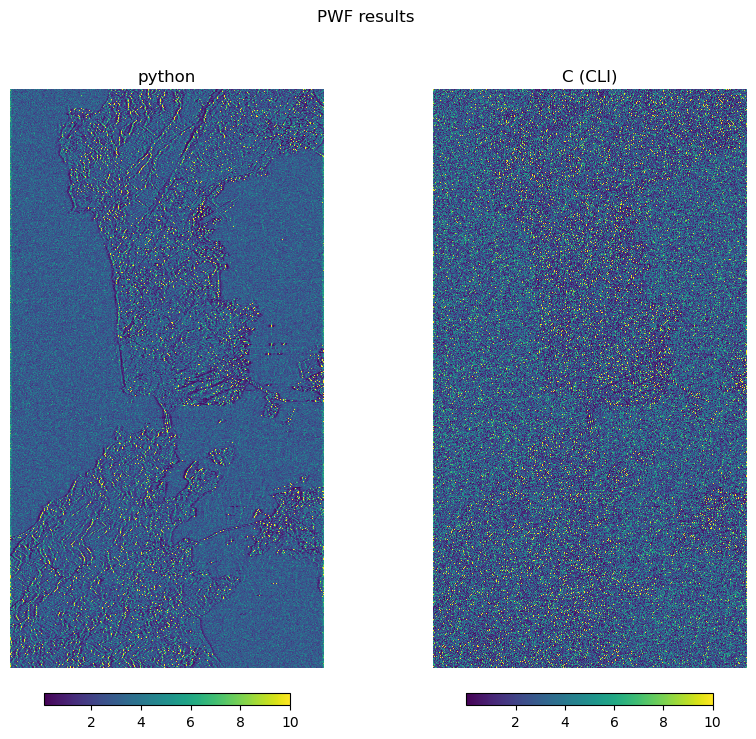

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.suptitle("PWF results")
plt.subplot(1,2,1)
plt.imshow(out_py["pwf"][::8], interpolation="none",vmax=10)
plt.colorbar(fraction=0.02, pad=0.04, location="bottom")
plt.axis("off")
plt.title("python")
plt.subplot(1,2,2)
plt.imshow(np.abs(out_c)[::8], interpolation="none",vmax=10)
plt.axis("off")
plt.colorbar(fraction=0.02, pad=0.04, location="bottom")
plt.title("C (CLI)")